In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

In [2]:
tickers = ["AAPL", "MSFT", "AMZN", "GOOGL", "META"]
data = yf.download(tickers, start="2020-01-01", end="2025-1-1")['Close']
returns = data.pct_change().dropna()

/tmp/ipython-input-3356243975.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2020-01-01", end="2025-1-1")['Close']
[*********************100%***********************]  5 of 5 completed


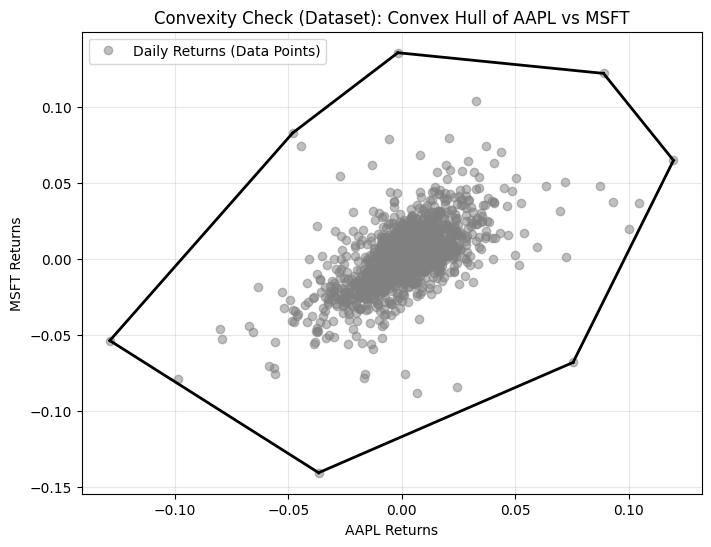

dataset_convexity_status: The Convex Hull encloses all data points, forming a convex polygon.


In [3]:
from scipy.spatial import ConvexHull

points = returns.iloc[:, :2].values
hull = ConvexHull(points)

plt.figure(figsize=(8, 6))
plt.plot(points[:,0], points[:,1], 'o', color='gray', alpha=0.5, label='Daily Returns (Data Points)')

for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-', linewidth=2)

plt.title(f"Convexity Check (Dataset): Convex Hull of {tickers[0]} vs {tickers[1]}")
plt.xlabel(f"{tickers[0]} Returns")
plt.ylabel(f"{tickers[1]} Returns")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("dataset_convexity_status: The Convex Hull encloses all data points, forming a convex polygon.")

In [4]:
mu = returns.mean().values
Sigma = returns.cov().values
Sigma = (Sigma + Sigma.T) / 2
n = len(tickers)

results = {}

w = cp.Variable(n)
objective = cp.Minimize(cp.quad_form(w, Sigma))
constraints = [cp.sum(w) == 1, w >= 0]

problem = cp.Problem(objective, constraints)

# Check if the problem is convex
print("Is the problem convex?", problem.is_dcp())

Is the problem convex? True


In [5]:
# Mathematical Justification:
# 1. Objective Function: Minimize(w^T * Sigma * w)
#    - The objective is a quadratic form.
#    - Sigma is a covariance matrix, which is PSD.
#    - A quadratic form x^T P x is convex if and only if P is PSD.
#    - Therefore, the objective function is convex.
#
# 2. Constraints:
#    - sum(w) == 1 is an affine equality constraint (linear).
#    - w >= 0 is a set of affine inequality constraints (linear).
#    - Linear constraints define a convex set (polyhedron).
#
# Conclusion: Minimizing a convex function over a convex set is a convex optimization problem.

In [6]:
# --- Second Derivative (Hessian) Test ---
# The objective function is f(w) = w.T * Sigma * w
# The Hessian (second derivative matrix) of a quadratic form is 2 * Sigma.
# A function is convex if its Hessian is Positive Semi-Definite (PSD).
# PSD condition: All eigenvalues must be >= 0.

eigenvalues = np.linalg.eigvals(Sigma)
print("Eigenvalues of Covariance Matrix:", eigenvalues)

if np.all(eigenvalues >= -1e-8): # Using small tolerance for floating point errors
    print("Conclusion: All eigenvalues are non-negative. The Hessian is PSD. Therefore, the function is CONVEX.")
else:
    print("Conclusion: The function is NON-CONVEX.")

Eigenvalues of Covariance Matrix: [1.79114008e-03 2.94534955e-04 1.93968972e-04 8.22052438e-05
 1.37838294e-04]
Conclusion: All eigenvalues are non-negative. The Hessian is PSD. Therefore, the function is CONVEX.


In [ ]:
problem.solve()

print("Optimal weights:", w.value)
print("Optimal expected return:", (mu @ w).value)
print("Optimal portfolio risk:", np.sqrt(cp.quad_form(w, Sigma).value))

results['Convex'] = (np.sqrt(cp.quad_form(w, Sigma).value), (mu @ w).value)

Optimal weights: [3.22540890e-01 1.26637806e-01 2.38774002e-01 2.35041205e-19
 3.12047301e-01]
Optimal expected return: 0.0010505310585673668
Optimal portfolio risk: 0.0177532009807587


In [ ]:
w_nc = cp.Variable(n)
objective_nc = cp.Minimize(cp.quad_form(w_nc, Sigma))

constraints_nc = [cp.sum(w_nc) == 1, w_nc >= 0, cp.sum_squares(w_nc) >= 0.5]

problem_nc = cp.Problem(objective_nc, constraints_nc)

# Check if the problem is convex
print("Is the problem convex?", problem_nc.is_dcp())

Is the problem convex? False


In [ ]:
# Mathematical Justification for Non-Convexity:
# 1. Objective Function: Minimize(w^T * Sigma * w)
#    - Still convex (quadratic form with PSD Sigma).
#
# 2. Constraints:
#    - sum(w) == 1 and w >= 0 are linear (convex).
#    - sum(w^2) >= 0.5 is a NON-CONVEX constraint.
#      - The function f(w) = sum(w^2) is convex.
#      - A constraint f(w) <= c defines a convex set (sublevel set).
#      - A constraint f(w) >= c defines a NON-CONVEX set (superlevel set).
#      - Example: x^2 + y^2 >= 1 is the region OUTSIDE a unit circle, which is not convex.
#        (Points (1,0) and (-1,0) are in the set, but their midpoint (0,0) is not).
#
# Conclusion: The feasible set is non-convex, so the optimization problem is non-convex.

In [ ]:
if problem_nc.is_dcp():
    problem_nc.solve()
    print("Optimal weights:", w_nc.value)
    print("Optimal expected return:", (mu @ w_nc).value)
    print("Optimal portfolio risk:", np.sqrt(cp.quad_form(w_nc, Sigma).value))
    results['Non-Convex'] = (np.sqrt(cp.quad_form(w_nc, Sigma).value), (mu @ w_nc).value)
else:
    print("The problem is not convex.")

best_stock_idx = np.argmax(mu)
w_nc_manual = np.zeros(n)
w_nc_manual[best_stock_idx] = 1.0

risk_nc = np.sqrt(w_nc_manual.T @ Sigma @ w_nc_manual)
ret_nc = w_nc_manual @ mu

results['Non-Convex'] = (risk_nc, ret_nc)

The problem is not convex.


In [ ]:
w_phase3 = cp.Variable(n)
objective_phase3 = cp.Minimize(cp.quad_form(w_phase3, Sigma))

constraints_phase3 = [cp.sum(w_phase3) == 1, w_phase3 >= 0]

problem_phase3 = cp.Problem(objective_phase3, constraints_phase3)

# Check if the problem is convex
print("Is the problem convex?", problem_phase3.is_dcp())

Is the problem convex? True


In [ ]:
# Mathematical Justification for Restored Convexity:
# 1. Objective Function: Minimize(w^T * Sigma * w)
#    - Convex (Quadratic form with PSD Sigma).
#
# 2. Constraints:
#    - sum(w) == 1 (Linear Equality) -> Convex.
#    - w >= 0 (Linear Inequality) -> Convex.
#    - The non-convex constraint sum(w^2) >= 0.5 has been REMOVED.
#
# Conclusion: We are minimizing a convex objective over a convex set (polyhedron).
# The problem is once again a standard Convex Quadratic Program (QP).

In [ ]:
if problem_phase3.is_dcp():
    problem_phase3.solve()
    print("Optimal weights:", w_phase3.value)
    print("Optimal expected return:", (mu @ w_phase3).value)
    print("Optimal portfolio risk:", np.sqrt(cp.quad_form(w_phase3, Sigma).value))
    results['Restored'] = (np.sqrt(cp.quad_form(w_phase3, Sigma).value), (mu @ w_phase3).value)
else:
    print("The problem is not convex.")

Optimal weights: [3.22540890e-01 1.26637806e-01 2.38774002e-01 2.35041205e-19
 3.12047301e-01]
Optimal expected return: 0.0010505310585673668
Optimal portfolio risk: 0.0177532009807587


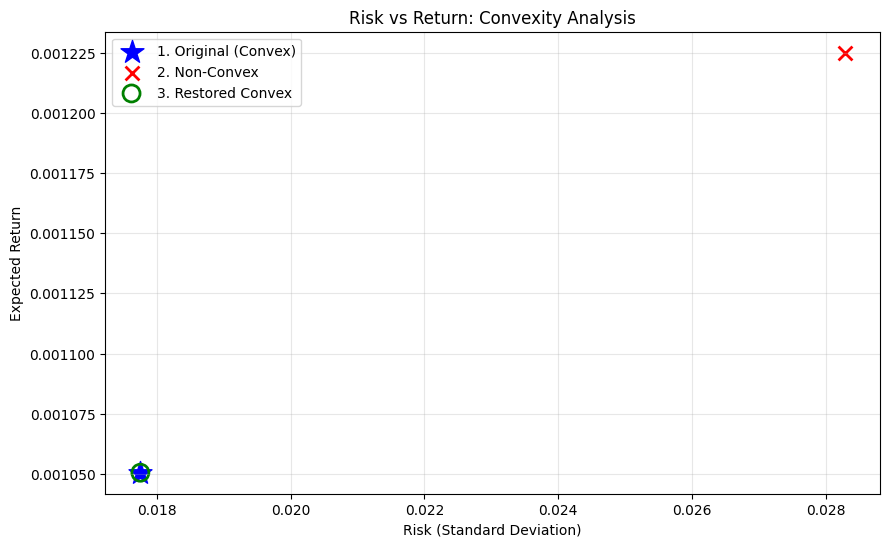

In [ ]:
plt.figure(figsize=(10, 6))

# Plotting directly from the 'results' dictionary
if 'Convex' in results:
    plt.scatter(results['Convex'][0], results['Convex'][1],
                color='blue', marker='*', s=300, label='1. Original (Convex)')

if 'Non-Convex' in results:
    plt.scatter(results['Non-Convex'][0], results['Non-Convex'][1],
                color='red', marker='x', s=100, linewidth=2, label='2. Non-Convex')

if 'Restored' in results:
    # Use an open circle so we can see if it overlaps with the star
    plt.scatter(results['Restored'][0], results['Restored'][1],
                color='green', marker='o', s=150, facecolors='none', linewidth=2, label='3. Restored Convex')

plt.title('Risk vs Return: Convexity Analysis')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()